# Prepare Renewable Potential

This tutorial contains various small guides for tasks you will need or come in handy in the upcoming group assignment.

We're going to need a couple of packages for this tutorial:

In [42]:
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import atlite
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import csv
import cartopy.crs as ccrs
import urllib

In [32]:
from scipy.sparse import csr_matrix

## Downloading historical weather data from ERA5 with `atlite`

First, let's load some small example country. Let's say, the Netherlands.

In [16]:
regions = gpd.read_file("gadm_410-levels-ADM_1-PHL.gpkg").set_index("GID_1")

regions = regions.rename
regions = regions.set_index("GID_1")
#sea_world = gpd.read_file('https://tubcloud.tu-berlin.de/s/5DYWwdtwpgBXAoy/download/eez_v11.gpkg')
#sea_regions = sea_world.loc[sea_world.TERRITORY1 == "Indonesia"]


#crs_code = 23830 # 3035
#crs_plot = 23830 # DGN95 / Indonesia TM-3 zone 46.2 https://epsg.io/23830

<AxesSubplot: >

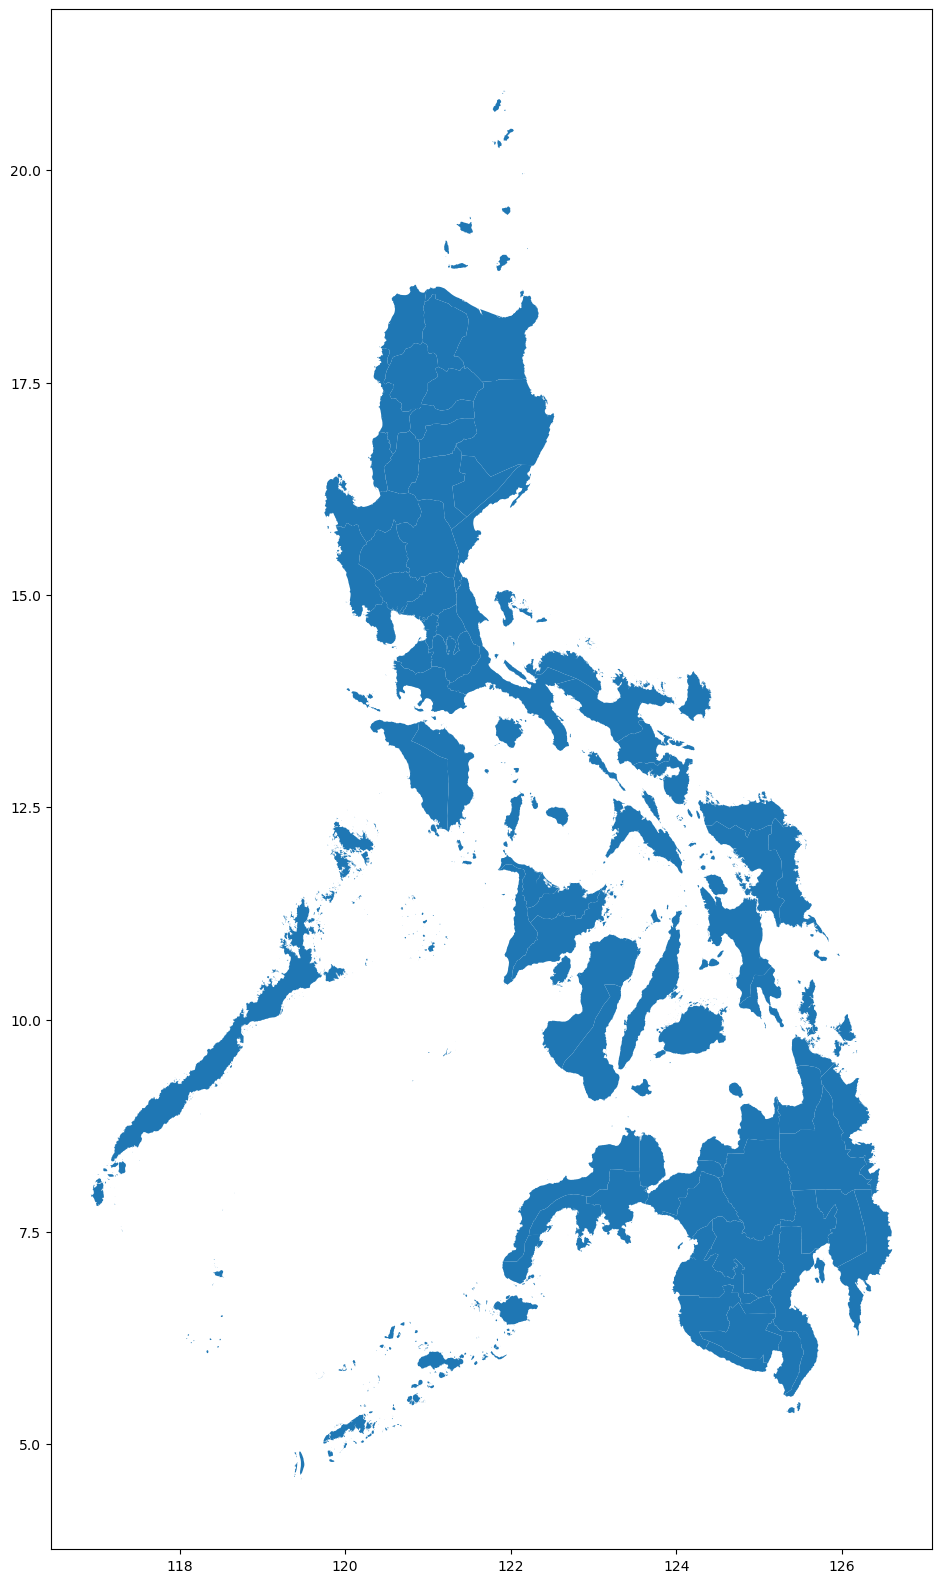

In [4]:
fig, ax = plt.subplots(figsize=(20,20))
regions.plot(ax=ax)
#sea_regions.plot(ax=ax)

In this example we download historical weather data [ERA5 data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) on-demand for a cutout we want to create.

:::{note}
For this example to work, you should have
- installed the Copernicus Climate Data Store `cdsapi` package (`conda list cdsapi` or `pip install cdsapi`) and
- registered and setup your CDS API key as described on [this website](https://cds.climate.copernicus.eu/api-how-to).
:::

A **cutout** is the basis for any of your work and calculations in `atlite`.

The cutout is created in the directory and file specified by the relative path. If a cutout at the given location already exists, then this command will simply load the cutout again. If the cutout does not yet exist, it will specify the new cutout to be created.

For creating the cutout, you need to specify the dataset (e.g. ERA5), a time period and the spatial extent (in latitude and longitude).

In [5]:
minx, miny, maxx, maxy = regions.total_bounds
buffer = 0.25

In [6]:
cutout = atlite.Cutout(
   path="PHL_atlite.nc",
   module="era5",
   x=slice(minx-buffer, maxx+buffer),
   y=slice(miny-buffer, maxy+buffer),
   time="2013",
)

Calling the function `cutout.prepare()` initiates the download and processing of the weather data.
Because the download needs to be provided by the CDS servers, this might take a while depending on the amount of data requested.

:::{note}
You can check the status of your request [here](https://cds.climate.copernicus.eu/cdsapp#!/yourrequests).
:::

In [8]:
cutout.prepare()

2023-05-07 16:05:49,316 INFO Storing temporary files in /tmp/tmp5etz4iu2
2023-05-07 16:05:49,323 INFO Calculating and writing with module era5:
2023-05-07 16:05:49,329 INFO Requesting data for feature temperature...
2023-05-07 16:05:49,333 INFO Requesting data for feature influx...
2023-05-07 16:05:49,337 INFO Requesting data for feature wind...
2023-05-07 16:05:49,340 INFO Requesting data for feature runoff...
2023-05-07 16:28:12,945 INFO CDS: Downloading variables
	 * 100m_u_component_of_wind (2013)
	 * 100m_v_component_of_wind (2013)
	 * forecast_surface_roughness (2013)

2023-05-07 16:28:43,302 INFO Requesting data for feature height...                                                                                                                                         
2023-05-07 16:36:14,241 INFO CDS: Downloading variables
	 * runoff (2013)

2023-05-07 16:50:17,660 INFO CDS: Downloading variables                                                                                    

[########################################] | 100% Completed | 8.53 sms


HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

<Cutout "PHL_atlite">
 x = 116.75 ⟷ 126.75, dx = 0.25
 y = 4.50 ⟷ 21.25, dy = 0.25
 time = 2013-01-01 ⟷ 2013-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [45]:
url = "https://tubcloud.tu-berlin.de/s/5XE2FWCfkRc4kAm/download/PHL_atlite.nc"

urllib.request.urlretrieve(url, "PHL_atlite_url.nc")

cutout = atlite.Cutout("PHL_atlite_url.nc") # if cutout is already prepared

In [34]:
cutout = atlite.Cutout("PHL_atlite.nc") # if cutout is already prepared

In [46]:
cutout.prepared_features

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                wnd_azimuth
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        influx           solar_altitude
        influx            solar_azimuth
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
dtype: object

<GeoAxesSubplot: xlabel='x', ylabel='y'>

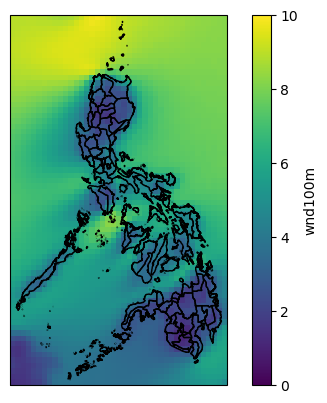

In [7]:
ax = plt.axes(projection=ccrs.PlateCarree())


cutout.data.wnd100m.mean(dim='time').plot(ax=ax, vmin=0, vmax=10)
regions.to_crs(4236).plot(ax=ax, edgecolor='k', color='none')

In [25]:
regions['PHL.1_1']

KeyError: 'PHL.1_1'

In [15]:
#regions.loc[regions.GID_1=='PHL.1_1']
regions

,GID_0,GID_1,COUNTRY,NAME_1,geometry
0,PHL,PHL.1_1,Philippines,Abra,"MULTIPOLYGON (((120.74773 17.15755, 120.73747 ..."
1,PHL,PHL.2_1,Philippines,Agusan del Norte,"MULTIPOLYGON (((125.51141 8.70021, 125.49689 8..."
2,PHL,PHL.3_1,Philippines,Agusan del Sur,"MULTIPOLYGON (((126.05209 7.93625, 126.04572 7..."
3,PHL,PHL.4_1,Philippines,Aklan,"MULTIPOLYGON (((122.28702 11.74581, 122.28805 ..."
4,PHL,PHL.5_1,Philippines,Albay,"MULTIPOLYGON (((123.44640 13.02776, 123.44541 ..."
...,...,...,...,...,...
76,PHL,PHL.77_1,Philippines,Tawi-Tawi,"MULTIPOLYGON (((119.93195 4.89917, 119.93195 4..."
77,PHL,PHL.78_1,Philippines,Zambales,"MULTIPOLYGON (((120.29529 14.80142, 120.29581 ..."
78,PHL,PHL.79_1,Philippines,Zamboanga del Norte,"MULTIPOLYGON (((121.90389 7.15028, 121.90417 7..."
79,PHL,PHL.80_1,Philippines,Zamboanga del Sur,"MULTIPOLYGON (((122.06706 6.86892, 122.06729 6..."


In [10]:
cutout.data.wnd100m

<xarray.DataArray 'wnd100m' (time: 8760, y: 68, x: 41)>
dask.array<open_dataset-24624d2300caba54dfc98d9dd3eb8badwnd100m, shape=(8760, 68, 41), dtype=float32, chunksize=(100, 68, 41), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 116.8 117.0 117.2 117.5 ... 126.0 126.2 126.5 126.8
  * y        (y) float64 4.5 4.75 5.0 5.25 5.5 ... 20.25 20.5 20.75 21.0 21.25
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    lon      (x) float64 dask.array<chunksize=(41,), meta=np.ndarray>
    lat      (y) float64 dask.array<chunksize=(68,), meta=np.ndarray>
Attributes:
    units:      m s**-1
    long_name:  100 metre wind speed
    module:     era5
    feature:    wind

In [74]:
cutout.data.wnd100m.to_pandas().head()

ValueError: Cannot convert arrays with 3 dimensions into pandas objects. Requires 2 or fewer dimensions.

In [87]:
cutout.indicatormatrix(regions, 4236)

<81x2788 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in List of Lists format>

In [ ]:
excluder_onwind = ExclusionContainer(crs=crs_code, res =100)

The data is accessible in `cutout.data`. Included weather variables are listed in `cutout.prepared_features`. Querying the `cutout` gives us some basic information on which data is contained in it.

## Eligible Area

In [8]:
def plot_area(masked, transform, shape, cmap_color):
    fig, ax = plt.subplots(figsize=(20,20))
    ax = show(masked, transform=transform, cmap=cmap_color, vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor='k', color='None', linewidth=1)
    #cutout.grid.to_crs(excluder_onwind.crs).plot(edgecolor='grey', color='None', ax=ax, ls=':')

### Eligible area onshore

In [9]:
excluder_onwind = ExclusionContainer(crs=crs_code, res =100)

#10km distance to airports
fn = 'https://tubcloud.tu-berlin.de/s/PndD5g72g6EKQwo/download/ne_10m_airports.gpkg'
excluder_onwind.add_geometry(fn, buffer=10000)

#300m distance to major roads
fn = 'https://tubcloud.tu-berlin.de/s/MDzsF75fxZkX9Ay/download/ne_10m_roads.gpkg'
excluder_onwind.add_geometry(fn, buffer=300)

#No natural protection areas
fn = 'https://tubcloud.tu-berlin.de/s/6zRNHD3xttaqWbQ/download/WDPA_Oct2022_Public_shp-IDN.tif'
excluder_onwind.add_raster(fn, crs=crs_code)

#maximum elevation of 2000m
fn = 'https://tubcloud.tu-berlin.de/s/tGALPbBS6m9W7cQ/download/GEBCO_2014_2D-ID.nc'
excluder_onwind.add_raster(fn, codes=lambda x: x>2000, crs=4326)

#1000m distance to built-up areas
fn = 'https://tubcloud.tu-berlin.de/s/n7Ctc8awK7B77Qj/download/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-ID.tif'
#code 50 refers to urban/built-up area (https://zenodo.org/record/4723921#.Y8RMRafMIvg, page 29)
excluder_onwind.add_raster(fn, codes = [50], buffer=1000, crs=4326)

#only on suitable land cover classes -> Include 10-forest, 20-Shrubs, 30-Herbaceous vegetation, 40-Cultivated and managed vegetation/agriculture (cropland), 60-Bare / sparse vegetation
codes_elig = [10, 20, 30, 40, 60]
excluder_onwind.add_raster(fn, codes= codes_elig, invert=True)


In [10]:
masked_onwind, transform_onwind = shape_availability(regions.to_crs(crs_code).geometry, excluder_onwind)

C:\Users\Nico\miniconda3\envs\esm\lib\site-packages\rasterio\features.py:322: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 62 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
C:\Users\Nico\miniconda3\envs\esm\lib\site-packages\rasterio\features.py:322: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 118 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
C:\Users\Nico\miniconda3\envs\esm\lib\site-packages\rasterio\features.py:322: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 328 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
C:\Users\Nico\miniconda3\envs\esm\lib\site-packages\rasteri

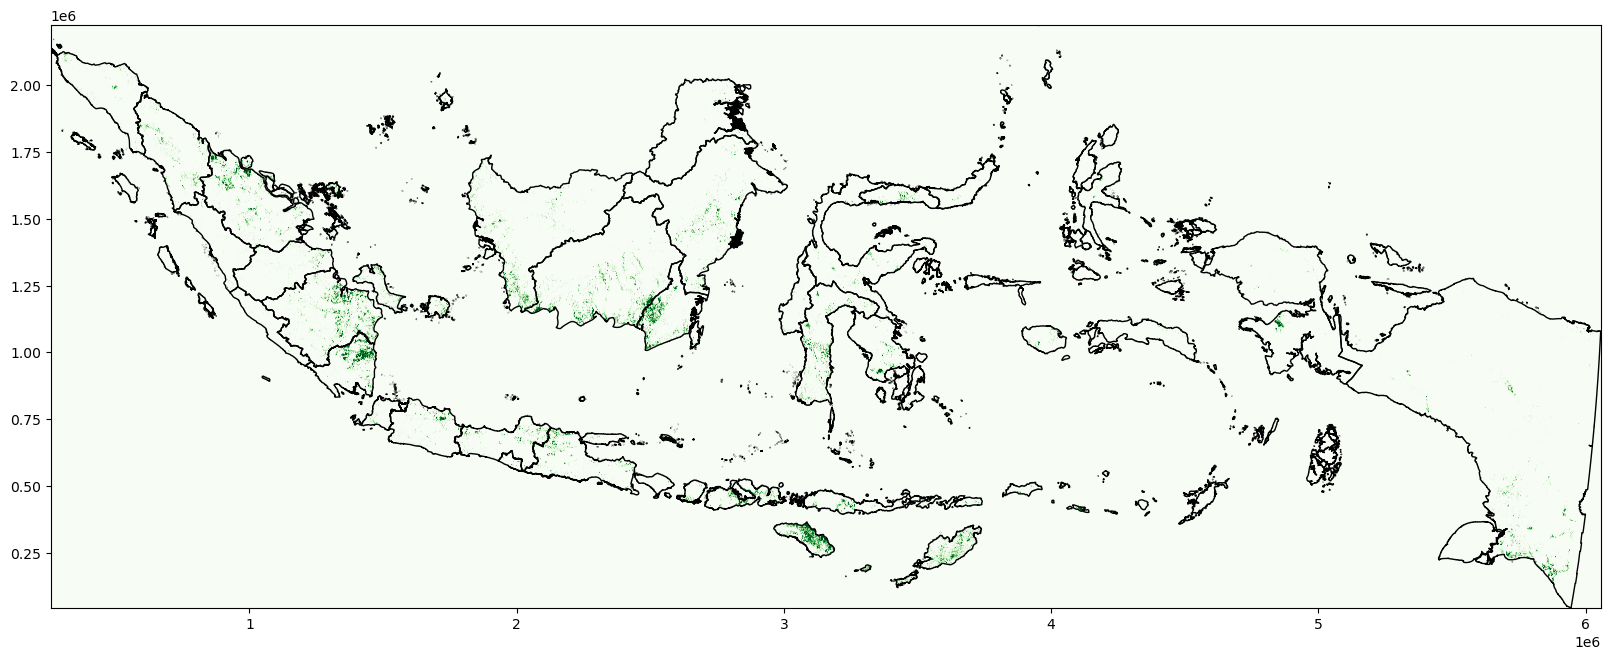

In [11]:
plot_area(masked_onwind, transform_onwind, regions.to_crs(crs_plot).geometry, "Greens")

### Eligible area offshore

### Availability Matrix

In [91]:
#regions.index = regions.GID_1
#cutout = atlite.Cutout("Indonesia_atlite.nc")
excluder = ExclusionContainer(res =100)
A = cutout.availabilitymatrix(regions, excluder)

Compute availability matrix: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  6.82 gridcells/s]


In [95]:
atlite.convert_and_aggregate(cutout

ValueError: Cannot convert arrays with 3 dimensions into pandas objects. Requires 2 or fewer dimensions.

In [20]:
def cap_matrix(regions, excluder):
    A = cutout.availabilitymatrix(regions, excluder)
    
    cap_per_sqkm = 3
    area = cutout.grid.set_index(['y', 'x']).to_crs(crs_code).area / 1e6
    area = xr.DataArray(area, dims=('spatial'))
    
    capacity_matrix = A.stack(spatial=['y', 'x']) * area * cap_per_sqkm
    
    return capacity_matrix

### Onshore Wind Profiles

In [30]:
onwind = cutout.wind(
    turbine = atlite.windturbines.Vestas_V112_3MW,
    matrix=cap_matrix(regions, excluder_onwind),
    index=regions.index,
    per_unit=True,
)

Compute availability matrix: 100%|██████████| 34/34 [04:42<00:00,  8.30s/ gridcells]


[########################################] | 100% Completed | 2.33 s


In [31]:
onwind.to_pandas().to_csv("onwind_cap.csv")